Looking at the difference between dollar bars and time bars. Hopefully dollar bars are more normal as well as defend against hedge funds expoiting retail behavior

In [1]:
data_path = '../Data/Kraken_Trading_History/'
coin_name = 'XBTUSD'
file_path = data_path + coin_name + '.csv'

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the data
df = pd.read_csv(file_path, header=None)
df.set_index(0, inplace=True)
df.columns = ['price', 'volume']
df['dollar_volume'] = df['price'] * df['volume']
df.index = pd.to_datetime(df.index, unit='s')


In [3]:
daily_close= df['price'].resample('1h').last()

<Axes: xlabel='0'>

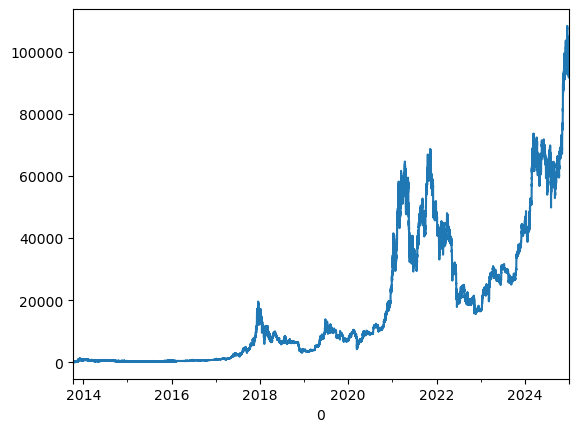

In [4]:
daily_close.plot()

In [5]:
import pandas as pd
import numpy as np

def create_dollar_bars_iterative_vectorized_carryover(df, rolling_median_window=20, bars_per_day=50):
    df = df.sort_index()
    
    bars = []
    # List to store daily total dollar volumes for rolling median calculation
    daily_totals = []
    
    carry_prices = np.array([], dtype=float)
    carry_volumes = np.array([], dtype=float)
    carry_dollar_vols = np.array([], dtype=float)
    carry_timestamps = np.array([], dtype='datetime64[ns]')
    
    for day, group in df.groupby(df.index.normalize()):
        group = group.sort_index()
        curr_prices = group['price'].values
        curr_volumes = group['volume'].values
        curr_dollar_vols = group['dollar_volume'].values
        curr_timestamps = group.index.to_numpy()
 
        day_total = curr_dollar_vols.sum()
        
        # Compute threshold using the rolling median of previous day totals
        if len(daily_totals) == 0:
            threshold = day_total / bars_per_day
        else:
            # Use the median over the last min(window, available days)
            window = daily_totals[-rolling_median_window:]
            median_total = np.median(window)
            threshold = median_total / bars_per_day

        # Adjust carryover timestamps to the start of the current day if any exist.
        if carry_timestamps.size > 0:
            carry_timestamps = np.full(carry_timestamps.shape, curr_timestamps[0])

        combined_prices = np.concatenate([carry_prices, curr_prices])
        combined_volumes = np.concatenate([carry_volumes, curr_volumes])
        combined_dollar_vols = np.concatenate([carry_dollar_vols, curr_dollar_vols])
        combined_timestamps = np.concatenate([carry_timestamps, curr_timestamps])

        cs = combined_dollar_vols.cumsum()
        start = 0 
        
        while start < len(cs):
            baseline = cs[start - 1] if start > 0 else 0
            target = baseline + threshold
            j = np.searchsorted(cs, target, side='left')
            if j >= len(cs):
                break
            bar_prices = combined_prices[start:j+1]
            bar_volumes = combined_volumes[start:j+1]
            bar_dollar_vols = combined_dollar_vols[start:j+1]
            
            open_price = bar_prices[0]
            high_price = bar_prices.max()
            low_price = bar_prices.min()
            close_price = bar_prices[-1]
            vwap = (bar_prices * bar_volumes).sum() / bar_volumes.sum()
            bar_volume = bar_volumes.sum()
            bar_dollar_sum = bar_dollar_vols.sum()
            bar_end_time = combined_timestamps[j]
            
            bars.append({
                'datetime': bar_end_time,
                'open': open_price,
                'high': high_price,
                'low': low_price,
                'close': close_price,
                'vwap': vwap,
                'volume': bar_volume,
                'dollar_volume': bar_dollar_sum
            })
            start = j + 1  
        
        if start < len(cs):
            carry_prices = combined_prices[start:]
            carry_volumes = combined_volumes[start:]
            carry_dollar_vols = combined_dollar_vols[start:]
            carry_timestamps = combined_timestamps[start:]
        else:
            carry_prices = np.array([], dtype=float)
            carry_volumes = np.array([], dtype=float)
            carry_dollar_vols = np.array([], dtype=float)
            carry_timestamps = np.array([], dtype='datetime64[ns]')
        
        # Append the current day's total to the list for future rolling median calculation.
        daily_totals.append(day_total)
    
    if carry_prices.size > 0:
        open_price = carry_prices[0]
        high_price = carry_prices.max()
        low_price = carry_prices.min()
        close_price = carry_prices[-1]
        vwap = (carry_prices * carry_volumes).sum() / carry_volumes.sum()
        bar_volume = carry_volumes.sum()
        bar_dollar_sum = carry_dollar_vols.sum()
        bar_end_time = carry_timestamps[-1]
        bars.append({
            'datetime': bar_end_time,
            'open': open_price,
            'high': high_price,
            'low': low_price,
            'close': close_price,
            'vwap': vwap,
            'volume': bar_volume,
            'dollar_volume': bar_dollar_sum
        })
    
    bars_df = pd.DataFrame(bars)
    bars_df.set_index('datetime', inplace=True)
    return bars_df



In [32]:
dollbars = create_dollar_bars_iterative_vectorized_carryover(df, rolling_median_window=20, bars_per_day=48)

In [33]:
import pickle

with open('../Data/all_ochl.pkl', 'rb') as f:
    cg_ohlc = pickle.load(f)

cg_ohlc = cg_ohlc[cg_ohlc['symbol'] == 'btc'].drop(['symbol', 'coin_id', 'name'], axis=1).set_index('time_rank')

In [34]:
import seaborn as sns
cg_log_ret = np.log(cg_ohlc['close']).diff()

In [35]:
p = print
p(cg_log_ret.describe())

count    61908.000000
mean         0.000035
std          0.007213
min         -0.193576
25%         -0.002367
50%          0.000052
75%          0.002541
max          0.157026
Name: close, dtype: float64


In [36]:
dolbar_log_ret = np.log(dollbars['close'].loc['2018-02-08':]).diff()

In [37]:
p(dolbar_log_ret.describe())

count    139983.000000
mean          0.000018
std           0.005222
min          -0.130930
25%          -0.002494
50%           0.000000
75%           0.002536
max           0.214378
Name: close, dtype: float64


In [38]:
hourly_log_ret = np.log(daily_close.loc['2018-02-08':]).diff()

In [39]:
p(hourly_log_ret.describe())

count    60422.000000
mean         0.000042
std          0.007341
min         -0.191412
25%         -0.002433
50%          0.000065
75%          0.002595
max          0.174218
Name: price, dtype: float64


In [40]:
p(dolbar_log_ret.autocorr(), hourly_log_ret.autocorr(), cg_log_ret.autocorr())

-0.024764092254318384 -0.025296962053145078 -0.0281201442177953


In [41]:
hourly_log_ret = np.log(daily_close.loc['2018-02-08':]).diff()

In [50]:
import sys
import os
sys.path.append(os.path.abspath('../Uncon Backtest'))
import util
p(util.entropy(dolbar_log_ret), util.entropy(cg_log_ret), util.entropy(np.log(dollbars['vwap'].loc['2018-02-08':]).diff()),
  util.entropy(hourly_log_ret))

0.17455650833594547 0.15316939676982605 0.0805546726796338 0.26902724914491793


In [43]:
p(dolbar_log_ret.resample('MS').std().std(), cg_log_ret.resample('MS').std().std(), hourly_log_ret.resample('MS').std().std())

0.001923505932342021 0.0027891853424091137 0.0028636436698260574


In [44]:
import scipy.stats as stats

p(stats.jarque_bera(dolbar_log_ret.dropna())[0], stats.jarque_bera(cg_log_ret.dropna())[0], stats.jarque_bera(hourly_log_ret.dropna())[0])

11185389.429453967 3461947.952601118 4272017.685359728


In [45]:
# Heteroskedasticity test
import statsmodels.api as sm
def white_test(data: pd.DataFrame, window: int = 21):
    data.dropna(inplace = True)
    data['std1'] = data['close'].rolling(12).std()
    data.dropna(inplace= True)
    X = sm.tools.tools.add_constant(data['close'])
    results = sm.regression.linear_model.OLS(data['std1'], X).fit()
    resid = results.resid
    exog = results.model.exog
    p("White-Test p-Value: {0}".format(sm.stats.het_white(resid, exog)[1]))
    if sm.stats.het_white(resid, exog)[1] > 0.05:
        p("White test outcome at 5% signficance: homoscedastic")
    else:
        p("White test outcome at 5% signficance: heteroscedastic")
p(white_test(pd.DataFrame(dolbar_log_ret.resample('d').mean(), columns=['close']), window=12),
  white_test(pd.DataFrame(cg_log_ret.resample('d').mean(), columns=['close']), window=12))

White-Test p-Value: 1.331140115403435e-70
White test outcome at 5% signficance: heteroscedastic
White-Test p-Value: 0.006154117928811055
White test outcome at 5% signficance: heteroscedastic
None None


In [46]:
p(sm.stats.het_arch(dolbar_log_ret.dropna())[0],
    sm.stats.het_arch(cg_log_ret.dropna())[0],
    sm.stats.het_arch(hourly_log_ret.dropna())[0])

4373.118583966346 5367.542190035239 4683.0629906600325


C:\Users\fujos\AppData\Local\Temp\ipykernel_30800\2371063559.py:1: FutureWarning: 'm' is deprecated and will be removed in a future version, please use 'ME' instead.
  dolbar_log_ret.resample('m').mean().plot()


<Axes: xlabel='datetime'>

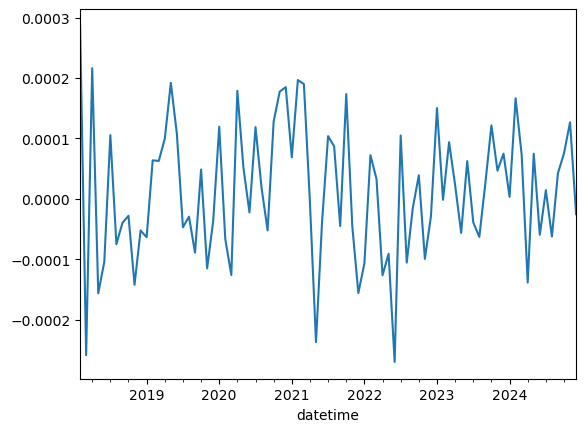

In [47]:
dolbar_log_ret.resample('m').mean().plot()

<Axes: xlabel='datetime'>

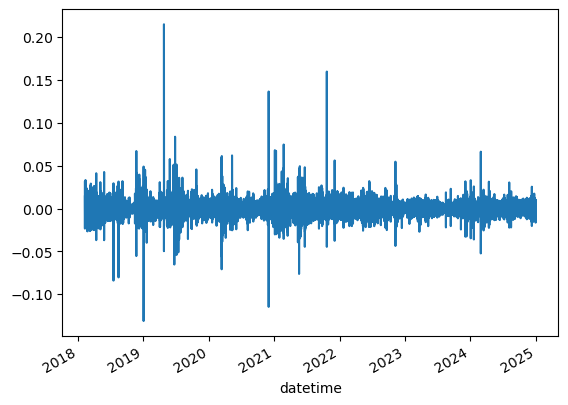

In [48]:
dolbar_log_ret.plot()

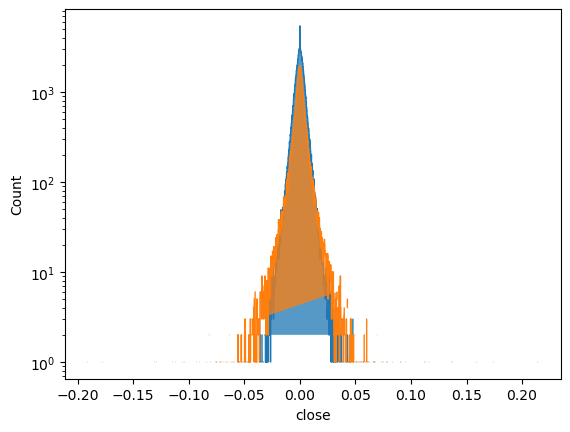

In [49]:
sns.histplot(dolbar_log_ret.dropna(), log_scale=(False, True), element='step')
sns.histplot(hourly_log_ret.dropna(), log_scale=(False, True), element='step')
plt.show()

In [61]:
dollbars.resample('d')['close'].count().describe()

count    4105.000000
mean       50.186114
std        38.998869
min         0.000000
25%        26.000000
50%        42.000000
75%        63.000000
max       403.000000
Name: close, dtype: float64

Conclusion

I don't think dollar bars have much advantage in terms of normality statistical properties. However, it does its job and may have better alpha synergy with strategies that may be optimized with trading activity lookback.